# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

plt.style.use('seaborn-v0_8')

import warnings
warnings.filterwarnings('ignore')

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [3]:
# Ваш код здесь
# Выполним проверку на пропуски данных
churn_data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [4]:
# Воспользуемся методом описательной статистики 
# для категориальных признаков
churn_data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [5]:
# Воспользуемся методом описательной статистики 
# для числовых признаков
churn_data.describe(exclude='object')

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


<Axes: xlabel='Exited', ylabel='count'>

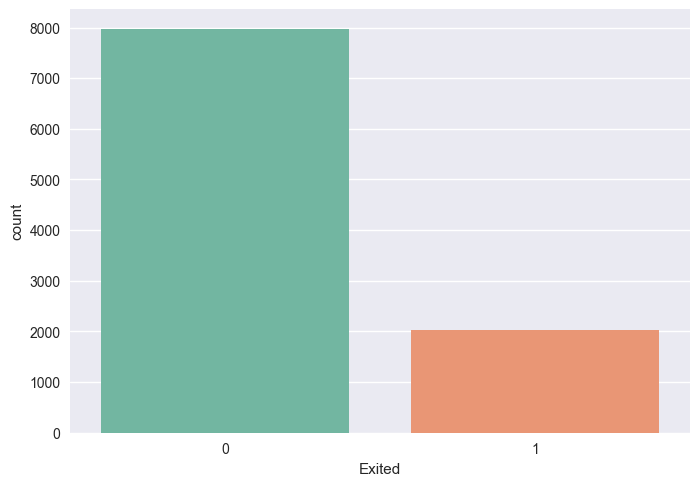

In [6]:
# Визуализируем распределение целевого признака 
sns.countplot(data = churn_data, x = 'Exited', palette='Set2')

In [7]:
feats_type = churn_data.dtypes
cat_feats = list(feats_type[feats_type == 'object'].index)
cat_feats

['Surname', 'Geography', 'Gender']

Мы получили мало признаков для визуализации, и, забегая вперед, признаки эти не информативные.

Для построения различных визуализаций создадим больше категориальных признаков, в новом ДФ, для понимания общих закономерностей и лучшего понимания поставленной проблемы. 

На основе категориальных, вновь созданных признаков, мы сможем произвести визуализацию взаимосвязи этих признаков и целевого признака. 

#### Преобразования числовых признаков в категориальные

In [8]:
# Создадим ДФ - копию, в котором будем создавать новые признаки
churn_data_vis = churn_data.copy()

In [9]:
# Создадим список числовых признаков
all_feats = list(churn_data.columns)
num_feats = all_feats.copy()
for elem in cat_feats[:2]:
    num_feats.remove(f'{elem}')
# Срезом удалим неинформативные признаки фамилии клиента и номера строки
num_feats = num_feats[2:]

Text(0.5, 0.98, 'Распределение числовых признаков')

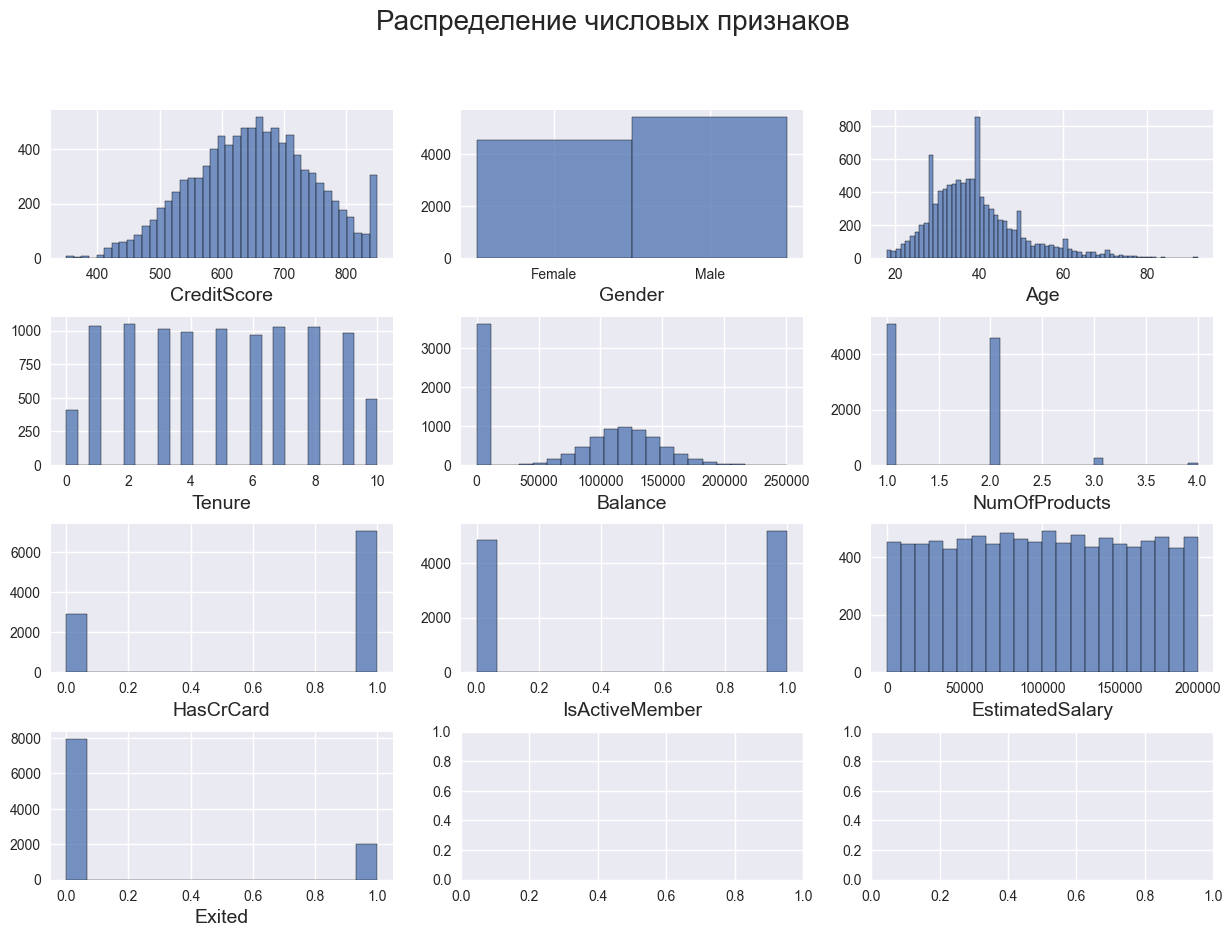

In [10]:
# Построим распределения признаков

# Зададим плоскость диаграмм и ее параметры
fig, ax = plt.subplots(ncols=3, nrows=4, figsize = (15,10))
plt.subplots_adjust(hspace=0.4)

# Счетчики для выбора нужной ячейки плоскости графиков
col = 0
row = 0

# Цикл для создания гистограмм рапределения числовых признаков
for elem in num_feats:
    hist = sns.histplot(
        data=churn_data,
        x = f'{elem}',
        ax=ax[row][col]
    )
    hist.set_xlabel(f'{elem}', fontsize = 14)
    hist.set_ylabel('')
    
    col += 1
    
    if col == 3:
        col = 0
        row += 1
plt.suptitle('Распределение числовых признаков', fontsize = 20)

О распределении признаков (нормально/ненормально) в контексте данного этапа говорить не будем. Отметим то, что, очевидно, часть признаков можно свести к категориальным. 

К ним относятся:
- CreditScore (Разобьем в диапазоны по 100)
- Age (Разобьем в диапазоны меньше 20 и далее по плюс 5 лет)
- Balance (Разобьем диапазонами по 25.000)
- EstimatedSalary (Так же, разобьем диапазонами по 25.000)

In [11]:
# Функция для создания нового признака, определяющая условный класс ЗП
def credit_score_classification(credit_score):
    """Функция для определения условного класса по кредитному
    рейтингу. Шаг прибавления (перехода к след классу) = 100
    Прибавление осуществляется циклом while

    Args:
        credit_score (int): Размер кредитного рейтинга

    Returns:
        int: Получившийся класс Кредитного рейтинга
    """
    
    credit_score_class = 0
    
    # Задаем "отправную точку расчета" ближайшая сотня от мин значения
    step = (churn_data_vis['CreditScore'].min() // 100) *100
    
    while credit_score > step:
        credit_score_class += 1
        step += 100
    
    return credit_score_class

# Функция для создания нового признака, определяющая условный класс ЗП
def age_classification(age):
    """Функция для определения условного класса по возрасту.
    Шаг прибавления (перехода к след классу) = 5. Отсчет начинается с 20
    Прибавление осуществляется циклом while

    Args:
        age (int): Возраст клиента

    Returns:
        int: Получившийся класс возраста
    """
    
    age_class = 1
    step = 20
    
    while age > step:
        age_class += 1
        step += 5
    
    return age_class

# Функция для создания нового признака, определяющая условный класс ЗП
def balance_and_salary_classification(money):
    """Функция для определения условного класса по зарплате или балансу.
    Шаг прибавления (перехода к след классу) = 25.000
    Прибавление осуществляется циклом while

    Args:
        money (float): Размер ожидаемой зарплаты / баланса клиента 

    Returns:
        int: Получившийся класс ЗП / баланса
    """
    
    sal_class = 1
    step = 25000
    
    while money > step:
        sal_class += 1
        step += 25000
    
    return sal_class

# Применим фукнции для создания новых признаков
churn_data_vis['Credit_score_class'] = \
    churn_data_vis['CreditScore'].apply(credit_score_classification)

churn_data_vis['Age_class'] = \
    churn_data_vis['Age'].apply(age_classification)

churn_data_vis['Balance_class'] = \
    churn_data_vis['Balance'].apply(balance_and_salary_classification)

churn_data_vis['Salary_class'] = \
    churn_data_vis['EstimatedSalary'].apply(balance_and_salary_classification)

# Дополним существующий список признаков вновь созданными 
# и удалим преобразованные признаки 
num_feats.append('Credit_score_class')
num_feats.remove('CreditScore')
num_feats.append('Age_class')
num_feats.remove('Age')
num_feats.append('Balance_class')
num_feats.remove('Balance')
num_feats.append('Salary_class')
num_feats.remove('EstimatedSalary')
num_feats.remove('Exited')


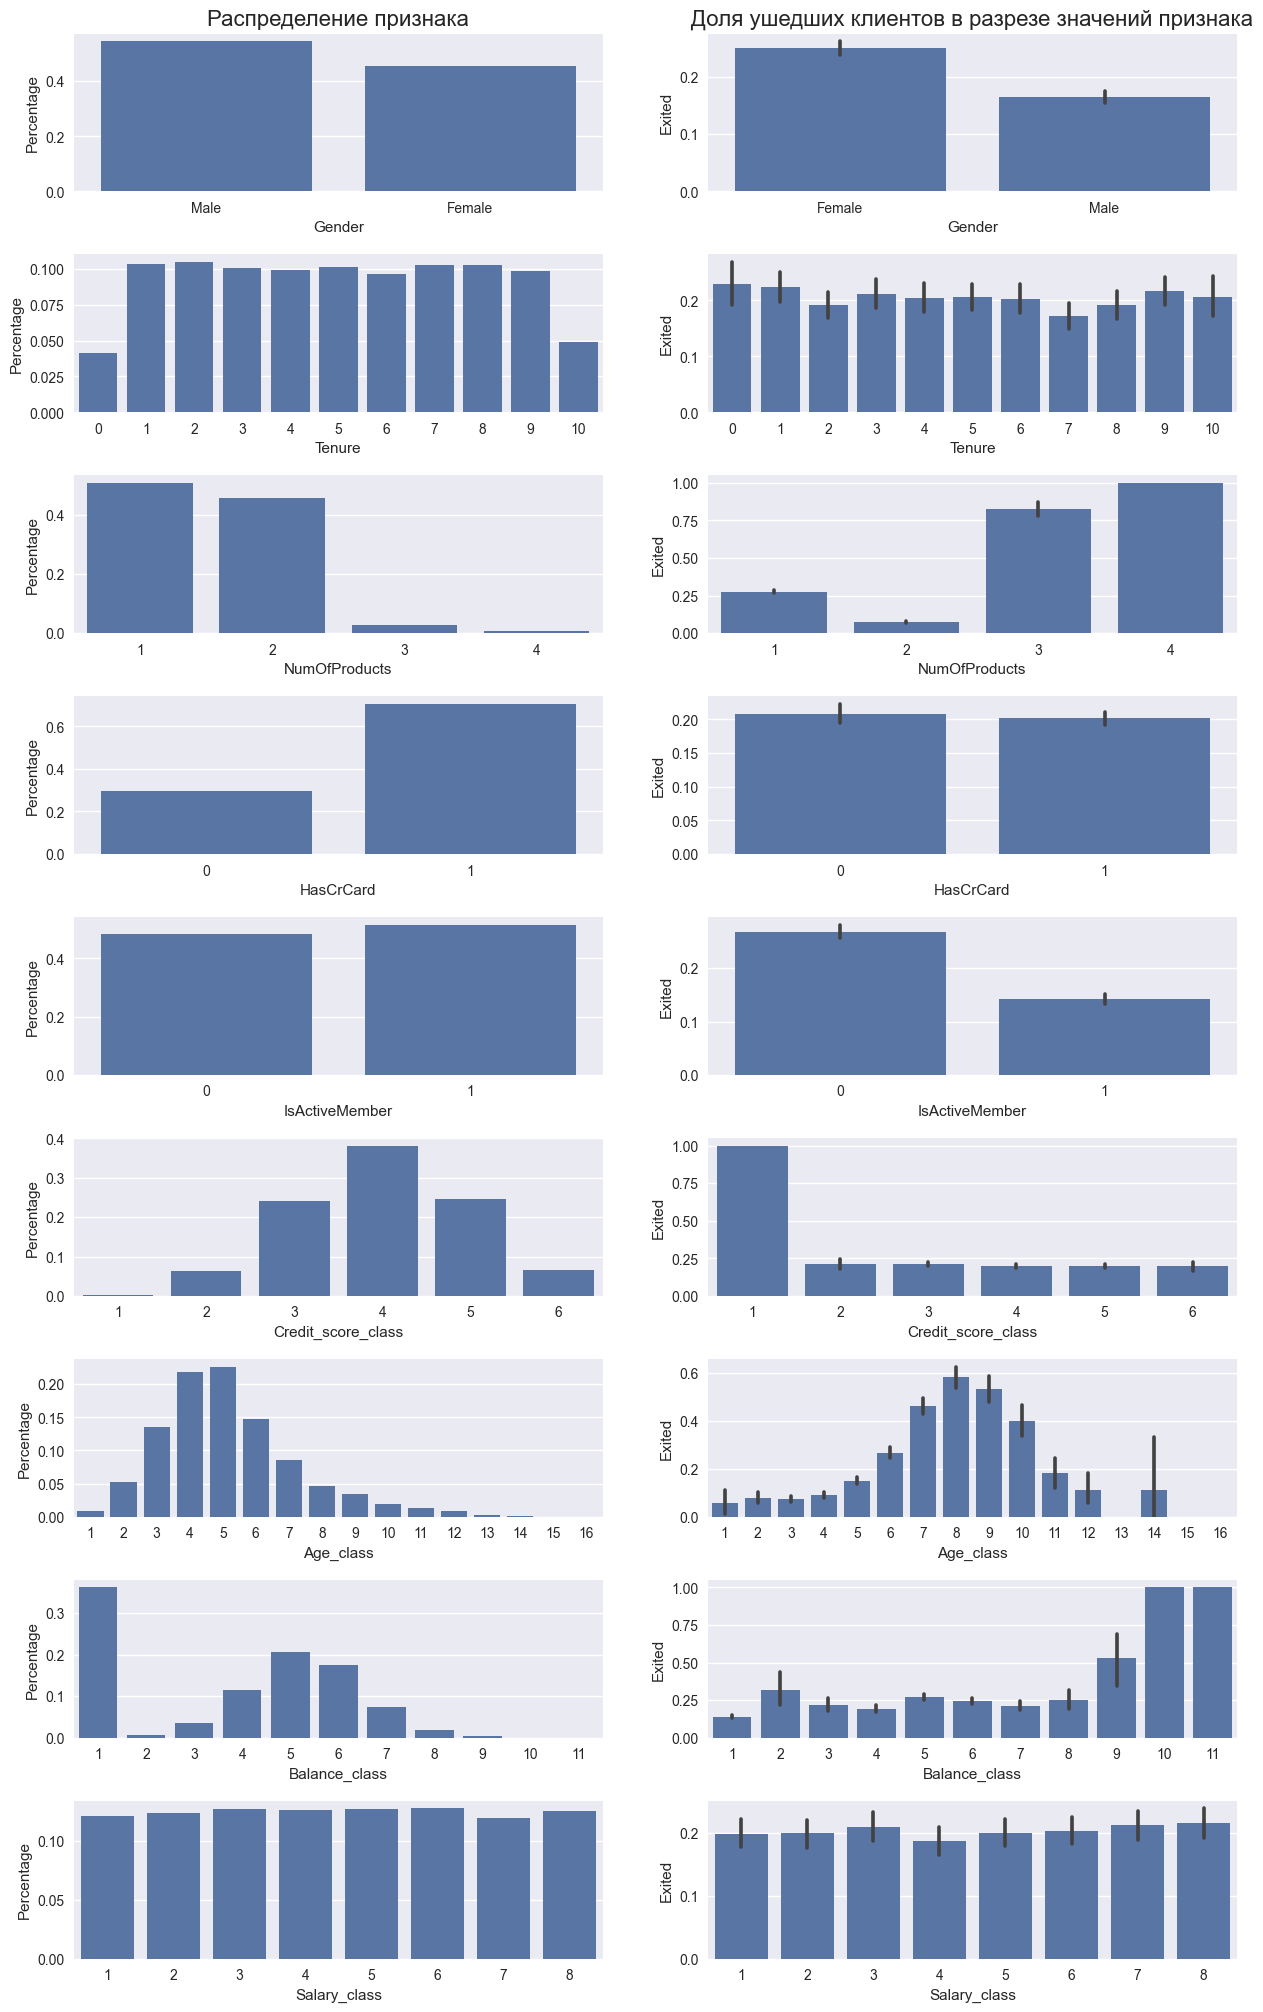

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=len(num_feats), figsize = (15, 25))
plt.subplots_adjust(hspace=0.4)

for i, feature in enumerate(num_feats):
    
    # Подготовим данные для построения в процентом выражении (сформируем 
    # новый ДФ, где значению признака будет соответствать его процент в признаке)
    count_data = (churn_data_vis[feature]
                  .value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    
    # Построим столбчатую диаграмму получившегося ДФ (признака)
    count_barplot = sns.barplot(
        data=count_data, 
        x=f'{feature}', 
        y='percentage', 
        ax=axes[i][0]
        )
    
    # Проименуем оси
    count_barplot.set_xlabel(f'{feature}')
    count_barplot.set_ylabel('Percentage')
    
    # Зададим заголовок для столбца графиков
    if i == 0:
        count_barplot.set_title(
            'Распределение признака', 
            fontsize = 16
            )
    
    # Построим стобчатые даграммы для признаков, 
    # которые продемострируют долю внутри признака ушедших клиентов
    bar_exited = sns.barplot(
        data = churn_data_vis,
        x = f'{feature}',
        y = 'Exited',
        ax = axes[i][1],        
        )
    
    # Проименуем оси
    bar_exited.set_xlabel(f'{feature}')
    
    # Зададим заголовок для столбца графиков
    if i == 0:
        bar_exited.set_title(
            'Доля ушедших клиентов в разрезе значений признака', 
            fontsize = 16
            )

По построенным графикам можно увидеть, что: 

- Четверть женщин - клиентов прекратили пользоваться услугами банка, при этом доля женщин в суммарном выражении клиентов немногим меньше мужской, этот фактор может быть важен.

- Распределение признака количества лет, в течении которых клиент имеет отношения с банком примерно одинаковое, за исключением лиц, являющихся клиентами первый год и 10ый год, таких клиентов меньше более чем в половину относительно других групп. А вот что же касается доли ушедших внутри каждой из групп признака - здесь отличительных особенностей не прослеживается. 

- Подалвяющее большинство клиентов банка пользуются одним либо двумя продуктами банка и эти группы примерно равны (клиентов с двумя продуктами немного меньше). А вот что касается доли ухода, здесь ситуация следующая, все клиенты, имевшие 4 продукта в банке ушли, клиенты же с тремя продуктами так же в большом оттоке - более 80 процентов ушедших. Стоит обратить особое внимание на клиентов с одним продуктом, доля ушедших примерно четверть, при этом, это самая многочисленная группа. 

- Наличие кредитной карты, вероятно, никак не оказывает влияние на уход, в обоих группах доля ушедших в процентном выражении одинакова. В целом по признаку, пятая часть клиентов имеет кредитную карту, остальные - не имеют. 

- Про признаку наличия активного статуса клиенты делятся примерно поровну. Но, доля ушедших клиентов больше среди группы не имеющей статус "активный клиент", это примерно четверть, когда в группе, имеющий статус "активный клиент" доля ушедших составляет около 15 процентов. 

- Наблюдается наибольший, стопроцентный отток клиентов с низким кредитным рейтингом, но, общее число клиентов этой группы малочисленно, так что этот фактор незначителей, скорее всего. По остальным группам признака особенностей нет. Разве что, стоит обратить внимание на 4-ую группу кредитного рейтинга, т.к. она наиболее многочислена. 

- Касаемо возраста, наиболее многочисленны возрастные классы 3-6 включительно (что соответствует 25-40 годам), а вот наивысшая доля ухода у клиентов классов 7-10 (45-60 лет).

- Примечателен факт, что клиенты с максимальным из представленного уровнями баланса (10, 11 классы) все покинули банк, хоть доля этих клиентов и крайне мала. Лидером по численности же является класс 1 (баланс до 25.000), он же имеет самую низкую долю ухода. Внутри классов 3-8 доля уходов схожа, по численности же из указанных классов лидируют 4-6 классы (100-150 к).

- По признаку ожидаемого уровня дохода у клиентов нельзя выделить что-то примечательное. Распределение очень ровное, как по численности групп, так и по доле ушедших клиентов внутри каждой группы.

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [13]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [14]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [15]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [16]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [17]:
# Создадим новые признаки:

# отношение баланса на счетах к заработной плате клиента 
churn_data['BalanceSalaryRatio'] = \
    churn_data['Balance'] / churn_data['EstimatedSalary']

# отношение времени пользования услугами банка к возрасту клиента 
churn_data['TenureByAge'] = \
    churn_data['Tenure'] / churn_data['Age']

# отношение кредитного рейтинга к возрасту клиента 
churn_data['CreditScoreGivenAge'] = \
    churn_data['CreditScore'] / churn_data['Age']   

In [18]:
# Кодировка оставшегося текстового признака в бинарную величину
churn_data['Gender'] = churn_data['Gender'].map(lambda x: 1 if x == 'Male' else 0)

In [19]:
# Проверим типы данных получившегося ДФ
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509 entries, 7 to 9998
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          2509 non-null   int64  
 1   Gender               2509 non-null   int64  
 2   Age                  2509 non-null   int64  
 3   Tenure               2509 non-null   int64  
 4   Balance              2509 non-null   float64
 5   NumOfProducts        2509 non-null   int64  
 6   HasCrCard            2509 non-null   int64  
 7   IsActiveMember       2509 non-null   int64  
 8   EstimatedSalary      2509 non-null   float64
 9   Exited               2509 non-null   int64  
 10  BalanceSalaryRatio   2509 non-null   float64
 11  TenureByAge          2509 non-null   float64
 12  CreditScoreGivenAge  2509 non-null   float64
dtypes: float64(5), int64(8)
memory usage: 274.4 KB


In [20]:
# Выведем основую статистическую информацию по признакам ДФ
churn_data.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,0.524512,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487
std,98.168937,0.499498,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558
min,350.000000,0.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676
25%,584.000000,0.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275
50%,651.000000,1.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143
75%,722.000000,1.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941
max,850.000000,1.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889


In [21]:
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [22]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [23]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0,
    test_size=0.2
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2007, 12)
Test shape: (502, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [25]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675635
1    0.324365
Name: proportion, dtype: float64



Test :


Exited
0    0.675299
1    0.324701
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

Для выбора способа масштабирования для начала определим как распределены наши данные. Проверим распределение значений признаков факторов (датафрейм X).
Так как число экземпляров ниже 5000, воспользуемся тестом Шапиро-Уилка.

In [26]:
# Ваш код здесь

# Импорт необходимого модуля библиотеки
from scipy import stats

# Задаем коэфициент значимости
alpha = 0.05

# Функция определения распределения, вывод итога на печать
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}.'
            ' Распределение {} отлично от нормального'.format(alpha, feat))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}.'
            ' Распределение {} является нормальным'.format(alpha, feat))

# Список признаков
X_cols = list(X.columns)

# Циклом вычислим p - значение распределения значений признаков
for feat in X_cols:
    data_to_check = X[f'{feat}'].values
    result = stats.shapiro(data_to_check)
    decision_normality(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение CreditScore отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение Gender отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение Age отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение Tenure отлично от нормального
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение Balance отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение NumOfProducts отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение HasCrCard отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение IsActiveMember отлично от нормального
p-value = 0.000
p-значение меньше, чем зада

На данном этапе мы выяснили, что ввиду отсутствия нормального рапсределения в значениях признаков применение такого метода масштабирования, как стандартизация невозможно. 

В таком случае осталось определиться какими методами из нормализации мы сможем воспользоваться. Ключевым в данном случае является наличие выбросов в данных каждого признака. 

Для этого произведем следующие действия: 
- Создадим три списка, в которые занесем названия признаков:
    - Список бинарных данных; 
    - список данных без выбросов, к которым можно применить метод нормализации MinMax;
    - список данных с выбросами, к которым можно применить метод нормализации Robust.
- Напишем и применим функцию, определяющую выбросы в данных. Выбросами будут считаться данные ушедшие за границы 3-ех межвартильных размахов.
- По созданным спискам произведем масштабирование данных, обучив их на учебной выборке. Масштабирование произведем отдельно тренировочной и тестовой выборок. 

In [27]:
# Пустые списки, занесем сюда названия признаков в зависимости 
# от типа значений и от наличия выбросов в данных
binary_feat_list = []
no_outlier_feat_list = []
with_outlier_feat_list = []

# Функция определения наличия выбросов 
def outlier_detection(feat):
    """Функкция для определения наличия выбросов в 
    данных признака ДФ. Используется определение данных вне 
    трех межквартильных размахов. 
    Так же, первым этапом отсекаются бинарные признаки. 
    Итог: занесение названий признаков в соответствующие списки

    Args:
        feat (str): Название признака ДФ
    """
    
    # Проверка на бинарность признака
    if X[f'{feat}'].nunique() <= 2:
        binary_feat_list.append(feat)
    
    else:
        # Вычисление границ выбросов ("усов") 
        x_25 = X[f'{feat}'].quantile(0.25)
        x_75 = X[f'{feat}'].quantile(0.75)
        left_board = x_25 - 1.5*(x_75 - x_25)
        right_board = x_75 + 1.5*(x_75 - x_25)
        
        # Счетчик для подсчета выбросов
        outlier_counter = 0
        
        # Проверка значений признака на нахождение внутри границ 3х 
        # межквартильных размахов
        for elem in X[f'{feat}']:
            if elem < left_board or elem > right_board:
                outlier_counter += 1
        
        # Занесение названия признака в соответствующий список, 
        # вывод итоговой информации по признаку на экран        
        if outlier_counter != 0:
            print(f'В значениях признака {feat} {outlier_counter} выбросов.')
            with_outlier_feat_list.append(feat)
        else:
            print(f'В значениях признака {feat} выбросов нет.')
            no_outlier_feat_list.append(feat)

# Применение функции определения выбросов по названию признака        
for feat in X_cols:
    outlier_detection(feat)

В значениях признака CreditScore 4 выбросов.
В значениях признака Age 70 выбросов.
В значениях признака Tenure выбросов нет.
В значениях признака Balance 33 выбросов.
В значениях признака NumOfProducts 24 выбросов.
В значениях признака EstimatedSalary выбросов нет.
В значениях признака BalanceSalaryRatio 298 выбросов.
В значениях признака TenureByAge 11 выбросов.
В значениях признака CreditScoreGivenAge 38 выбросов.


In [28]:
# Выведем на экран полученные списки признаков
print('Список бинарных признаков:', binary_feat_list) 
print('Список признаков для с отсутствием выбросов:', no_outlier_feat_list)
print('Список признаков для с наличием выбросов:', with_outlier_feat_list)

Список бинарных признаков: ['Gender', 'HasCrCard', 'IsActiveMember']
Список признаков для с отсутствием выбросов: ['Tenure', 'EstimatedSalary']
Список признаков для с наличием выбросов: ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'BalanceSalaryRatio', 'TenureByAge', 'CreditScoreGivenAge']


Посмотрим на распределение значений в признаках с выборосами более внимательно. Для этого построим коробчатые диаграммы.

Text(0.5, 0.98, 'Коробчатые диаграммы значений признаков, имеющих выбросы')

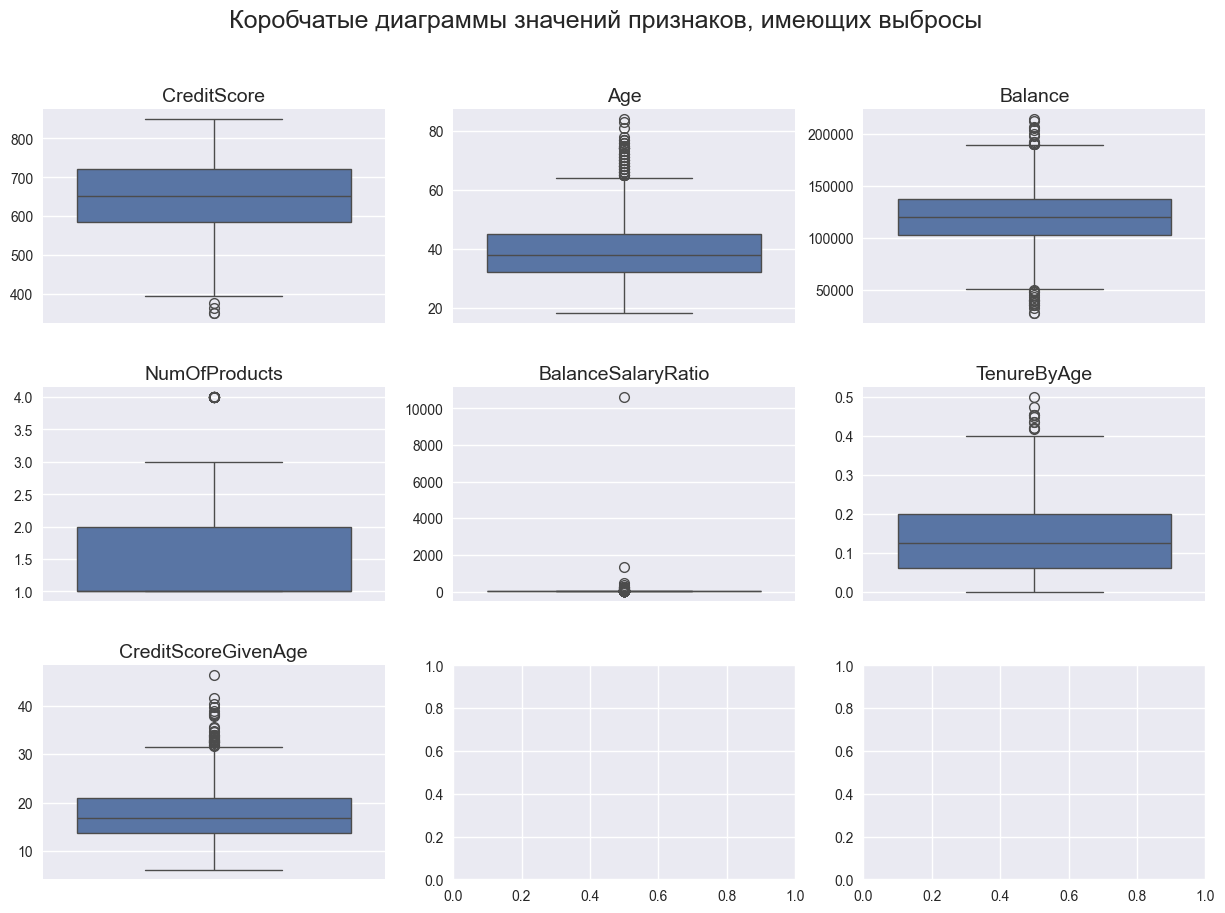

In [29]:
fig, axes = plt.subplots(nrows= 3, ncols=3, figsize = (15,10))
plt.subplots_adjust(hspace=0.3)

row = 0
col = 0

for feat in with_outlier_feat_list:
    box = sns.boxplot(
        data = X[f'{feat}'],
        ax = axes[row][col]
        )
    box.set_ylabel('')
    box.set_title(f'{feat}', fontsize = 14)
        
    col += 1
    if col == 3:
        col = 0
        row += 1

plt.suptitle(
    'Коробчатые диаграммы значений признаков, имеющих выбросы',
    fontsize = 18
    )

**Выбор метода масштабирования данных**

По результатам анализа данных возникает неоднозначная ситуация. С одной стороны, мы имеем большое количество признаков, в данных которых имеются выбросы. С другой стороны, выбросы эти на так уж и далеки от границ. Фактически, из признаков, обладающих прямо большими выбросами, можно выделить BalanceSalaryRatio. Так же, можно сюда отнести признаки CreditScoreGivenAge, Age. 

Список бинарных признаков будем добавлять к различным спискам "комбинированных" масштабирований. Для _most_minmax и _middle_minmax список будет передан в список данных для масштабирования MinMax (т.е. не поменяет по итогу своих значений), для данных _most_robust будет передан в список данных для масштабирования при помощи Robust. 

Таким образом, для дальнейшего получения лучших показателей метрик будущих моделей, произведем подготовку трех данных с указаниями (суффиксами): 

- _most_minmax - масштабируются все признаки, кроме BalanceSalaryRatio при помощи метода MinMax Scaller (вместе с бинарными)
- _middle_minmax - масштабируется большиство признаков при помощи MinMax Scaller (вместе с бинарными), три признака - при помощи RobustScaller (BalanceSalaryRatio, CreditScoreGivenAge, Age)
- _most_robust - масштабируются "по правилам" все данные с выбросами (по списку with_outlier_feat_list), коих большинство, при помощи RobustScaller (вместе с бинарными), а данные без выбросов (по списку no_outlier_feat_list) при помощи MinMaxScaller
- _robust - все данные масштабированы при помощи RobustScaller 
- _minmax - все данные масштабированы при помощи MinMax

**Подготовка списков признаков для масштабирования, с учетом разных подходов к выбору метода масштабирования**

In [30]:
# Список признаков для масштабирования Robust для _most_minmax
feats_robust_most_minmax = ['BalanceSalaryRatio']

# Список признаков для масштабирования MinMax для _most_minmax

feats_minmax_most_minmax = list(X.columns)
feats_minmax_most_minmax.remove('BalanceSalaryRatio')


# Список признаков для масштабирования Robust для _middle_minmax
feats_robust_middle_minmax = ['BalanceSalaryRatio', 'CreditScoreGivenAge', 'Age']

# Список признаков для масштабирования MinMax для _middle_minmax
# Формируем при помощи list comprehesion по условию не вхождения в список Robust
feats_minmax_middle_minmax = \
    [elem for elem in list(X.columns) if elem not in feats_robust_middle_minmax]



# Список признаков для масштабирования Robust для _most_robust
feats_robust_most_robust = with_outlier_feat_list.copy()
feats_robust_most_robust = feats_robust_most_robust + binary_feat_list

# Список признаков для масштабирования MinMax для _most_robust
feats_minmax_most_robust = no_outlier_feat_list.copy()

**Подготовка скейлеров, с учетом разных подходов к выбору метода масштабирования**

In [31]:
# Создание скейлеров для первой группы _most_minmax
r_scaller_most_minmax = preprocessing.RobustScaler()
r_scaller_most_minmax.fit(X_train[feats_robust_most_minmax])

mm_scaller_most_minmax = preprocessing.MinMaxScaler()
mm_scaller_most_minmax.fit(X_train[feats_minmax_most_minmax])

MinMaxScaler()

In [32]:
# Создание скейлеров для второй группы _middle_minmax
r_scaller_middle_minmax = preprocessing.RobustScaler()
r_scaller_middle_minmax.fit(X_train[feats_robust_middle_minmax])

mm_scaller_middle_minmax = preprocessing.MinMaxScaler()
mm_scaller_middle_minmax.fit(X_train[feats_minmax_middle_minmax])


MinMaxScaler()

In [33]:
# Создание скейлеров для третьей группы _most_robust
r_scaller_most_robust = preprocessing.RobustScaler()
r_scaller_most_robust.fit(X_train[feats_robust_most_robust])

mm_scaller_most_robust = preprocessing.MinMaxScaler()
mm_scaller_most_robust.fit(X_train[feats_minmax_most_robust])

MinMaxScaler()

In [34]:
# Создание скейлера для четвертой группы _robust
r_scaller_robust = preprocessing.RobustScaler()
r_scaller_robust.fit(X_train[list(X.columns)])

RobustScaler()

In [35]:
# Создание скейлера для пятой группы _minmax
mm_scaller_minmax = preprocessing.MinMaxScaler()
mm_scaller_minmax.fit(X_train[list(X.columns)])

MinMaxScaler()

**Нормализация значений тренировочных и тестовых выборок по группам**

In [36]:
# Нормализация значений признаков 
# тренировочной и тестовой выборок первой группы _most_minmax

X_train_most_minmax = X_train.copy()

X_train_most_minmax[feats_robust_most_minmax] = \
    r_scaller_most_minmax.transform(X_train[feats_robust_most_minmax])
X_train_most_minmax[feats_minmax_most_minmax] = \
    mm_scaller_most_minmax.transform(X_train[feats_minmax_most_minmax])


X_test_most_minmax = X_test.copy()

X_test_most_minmax[feats_robust_most_minmax] = \
    r_scaller_most_minmax.transform(X_test[feats_robust_most_minmax])
X_test_most_minmax[feats_minmax_most_minmax] = \
    mm_scaller_most_minmax.transform(X_test[feats_minmax_most_minmax])


In [37]:
# Нормализация значений признаков 
# тренировочной и тестовой выборок второй группы _middle_minmax

X_train_middle_minmax = X_train.copy()

X_train_middle_minmax[feats_robust_middle_minmax] = \
    r_scaller_middle_minmax.transform(X_train[feats_robust_middle_minmax])
X_train_middle_minmax[feats_minmax_middle_minmax] = \
    mm_scaller_middle_minmax.transform(X_train[feats_minmax_middle_minmax])


X_test_middle_minmax = X_test.copy()

X_test_middle_minmax[feats_robust_middle_minmax] = \
    r_scaller_middle_minmax.transform(X_test[feats_robust_middle_minmax])
X_test_middle_minmax[feats_minmax_middle_minmax] = \
    mm_scaller_middle_minmax.transform(X_test[feats_minmax_middle_minmax])

In [38]:
# Нормализация значений признаков 
# тренировочной и тестовой выборок третьей группы _most_robust

X_train_most_robust = X_train.copy()

X_train_most_robust[feats_robust_most_robust] = \
    r_scaller_most_robust.transform(X_train[feats_robust_most_robust])
X_train_most_robust[feats_minmax_most_robust] = \
    mm_scaller_most_robust.transform(X_train[feats_minmax_most_robust])


X_test_most_robust = X_test.copy()

X_test_most_robust[feats_robust_most_robust] = \
    r_scaller_most_robust.transform(X_test[feats_robust_most_robust])
X_test_most_robust[feats_minmax_most_robust] = \
    mm_scaller_most_robust.transform(X_test[feats_minmax_most_robust])

In [39]:
# Нормализация значений признаков 
# тренировочной и тестовой выборок четвертой группы _robust

X_train_robust = r_scaller_robust.transform(X_train)
X_test_robust = r_scaller_robust.transform(X_test)

In [40]:
# Нормализация значений признаков 
# тренировочной и тестовой выборок пятой группы _minmax

X_train_minmax = mm_scaller_minmax.transform(X_train)
X_test_minmax = mm_scaller_minmax.transform(X_test)


Итого, мы получили четыре набора нормализованных разными способами значений факторов в тренировочной и тестовой выборках: 

- **X_train_most_minmax** &nbsp;&nbsp;и&nbsp;&nbsp; **X_test_most_minmax**

- **X_train_middle_minmax** &nbsp;&nbsp;и&nbsp;&nbsp; **X_test_middle_minmax**

- **X_train_most_robust** &nbsp;&nbsp;и&nbsp;&nbsp; **X_test_most_robust**

- **X_train_robust** &nbsp;&nbsp;и&nbsp;&nbsp; **X_test_robust**

- **X_train_minmax** &nbsp;&nbsp;и&nbsp;&nbsp; **X_test_minmax**


Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Для решения данной задачи подойдёт метрика F-мера. Данная метрика является балансом между метриками precission и recall, т.е. балансом между вероятностями допустить ошибки первого и ошибки второго рода. 

> Ввиду того, что условием задачи не упоминается необходимость однозначного определения ушедших клиентов "любой ценой", и, прибегая к здравому смыслу, что для потенциально уходящих клиентов будут предложены какие-то программы лояльности, т.е. компания будет затрачивать финансовые ресурсы (и/или уменьшать прибыль от этих клиентов), метрику recall мы не рассматриваем (даст большее число ложноположительных результатов).

> Применить более простую метрику accurancy в данном случае не выйдет ввиду несбалансированности классов. 

> Ниже приведена диаграмма, отображающая несбаланированность значений целевого признака.  

Text(0.5, 1.0, 'Распределение ушедших и лояльных клиентов')

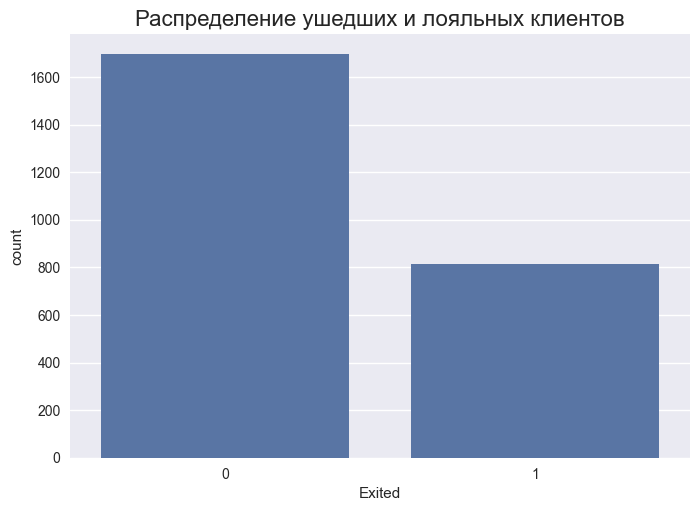

In [41]:
fig = sns.countplot(
    pd.DataFrame(y, columns=['Exited']), 
    x = 'Exited',
    )
fig.set_title('Распределение ушедших и лояльных клиентов', fontsize = 16)

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Для оптимизации работы и возможности рассмотреть различные модели и результаты их работы, принимая во внимание уже наличие пяти заготовленных ДФ с данными и многообразие методов и параметров модели, поступим следующим образом: 

- создадим список, элементы которого являются списки с данными для обработки, и названиями методов масштабирования, проведенных с ними 
- напишем одну универсальную функцию, которая позволит нам, меняя параметры подаваемых аргументов, получать результаты работы моделей при различных ее параметрах, с выводом результатов в виде графиков на экран 
- выберем параметры функции и тип масштабирования данных, которые покажут наилучший результат, и будем далее работать с ними. 

In [42]:
# Прописать список с данными, затем написать функцию (одну), длы модели, с графиками, подбором параметров и т.п.

variety_scalings_list = [
    [X_train_most_minmax, X_test_most_minmax, 'Результаты для данных _most_minmax'],
    [X_train_middle_minmax, X_test_middle_minmax, 'Результаты для данных _middle_minmax'],
    [X_train_most_robust, X_test_most_robust, 'Результаты для данных _most_robust'],
    [X_train_robust, X_test_robust, 'Результаты для данных _scaled'],
    [X_train_minmax, X_test_minmax, 'Результат для данных _minmax']
    ]


### !!! Проверяющему ментору: 

*Здравствуйте,*

*в виду большого количества вариаций параметров модели логистической регрессии, принял решение написать общую функцию, которую можно использовать, меняя падаваемые на нее параметры. В дальнейшем, это позволит сэкономить время на написание кода. Так же, воспользовавшись данной функцией "на максимальном режиме", т.е. со всем вариациями параметров, мы безошибочно сможем выбрать лучшие параметри для модели.* 

*Плюс, данную функцию в дальнейшем можно использовать как универсальную.* 

*Надеюсь, такое отхождение от структуры работы будет воспринято с пониманием  : )* 

In [43]:
#### VERSION 3


def logreg_param_select(
    X_train, X_test, standartisation_name, 
    solver_names=['all'], penalty_method=['all'],
    C_values = (0.01, 10, 0.1)):
    """Функция для проверки работы модели логистической регрессии с учетом разных 
    подаваемых на нее данных. 
    Можно задавать численные методы оптимизации функции ошибок
    Метод регуляризации, 
    Задавать границы и шаг для массива значений C-фактора. 
    
    По умолчанию значения стоят "на максималках", по желанию можно задать что-то конкретное. 
    По результатуту функция стрроит график F-1 метрики, а так же возвращает словарь с метриками. 
    
    !!! Функция не работает с методом регуляризации elascticnet !!! 

    Args:
        X_train (DF): Тренировочная выборка для модели
        X_test (DF): Тестовая выборка для модели
        
        standartisation_name (str): Текстовое описание метода нормализации данных выборки
        solver_names (list, optional): Численный метод нормализации ошибки, который(-ые)
            планируется проверять . Defaults to ['all'].
        penalty_method (list, optional): Метод(-ы) регуляризации, 
            который(-ые) планируется проверять. Defaults to ['all'].
        C_values (tuple, optional): Значения кортежа - int or float
            Данные для задания массива чисел в качестве значений 
            C - фактора . Defaults to (0.01, 10, 0.1).

    Raises:
        NameError: Вызов ошибки при неправильно введенном имени численного метода
                    оптимизации ошибки
        NameError: Вызов ошибки при неправильно введенном имени метода регуляризации
        NameError: Вызов ошибки при попытке использования 
                    метода регулярации elasticknet. В данной функции он не реализован
                    Ввиду того, что размерность полученных данных будет отличаться 
                    от всех остальных (добавляет L1-Ratio). 
        NameError: Вызов ошибки при неправильно введенном имени метода регуляризации
        NameError: Вызов ошибки при неправильно введенном имени метода регуляризации

    Returns:
        DF: итоговый ДФ с метриками при различных вариациях поданных параметров на 
        модель логистической регрессии.
    """

    # Словарь - итоговый - будет содержать f-1 метрики всех моделей, учитывая параметры
    models_metric_values = {}
    
    ### Задание численных методов оптимизации функции 
    ### И проверка поданных на функцию значений 
    
    # Список всех численных методов оптимизации функции потерь
    # функции логистической регрессии 
    solver_names_all = ['liblinear', 'lbfgs', 'newton-cg', 
                       'newton-cholesky', 'sag', 'saga']
    
    if solver_names == ['all']:
        solver_names = solver_names_all.copy()
   
    else:
        for elem in solver_names:
            
            if elem not in solver_names_all:
                raise NameError ('Wrong solver name')
            
            else:    
                solver_names = solver_names
    
    for solver_name in solver_names:
        
        ### НАЧАЛО: БЛОК ПРОВЕРКИ МЕТОДОВ РЕГУЛЯРИЗАЦИИ
        
        ### Задание методов регуляризации в зависимости от численного метода
        ### и поданных на функцию значений, так же их проверка на корректность    

        if solver_name in ['liblinear']:
            
            if penalty_method == ['all']:
                penalty_method_current = ['l1', 'l2']
            
            else:
                for elem in penalty_method:
                    
                    if elem not in ['l1', 'l2']:
                        raise NameError ('Wrong penalty method 1')
                    
                    else:
                        penalty_method_current = penalty_method
        
        elif solver_name in ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']:
            
            if penalty_method == ['all']:
                penalty_method_current = ['l2', 'no_penalty']
            
            else:
                for elem in penalty_method:
                    
                    if elem not in ['l2', 'no_penalty']:
                        raise NameError (f'Wrong penalty method 2 {elem} {solver_name}')
                    
                    else:
                        penalty_method_current = penalty_method

        elif solver_name in ['saga']:
            
            if penalty_method == ['all']:
                penalty_method_current = ['l1', 'l2', 'no_penalty']
            
            elif penalty_method == ['elasticnet']:
                raise NameError("This finction doesn't support elasticnet penalty " 
                        "due to difference of data shapes")
            
            else:
                for elem in penalty_method:
                    
                    if elem not in ['l1', 'l2', 'no_penalty']:
                        raise NameError ('Wrong penalty method 3')
                
                    else:
                        penalty_method_current = penalty_method
        
        ### КОНЕЦ: БЛОК ПРОВЕРКИ МЕТОДОВ РЕГУЛЯРИЗАЦИИ
    
    
        # Создаем словарь, куда будем заносить значения метрик моделей при различных
        # значениях С-фактора, с учетом типов масштабированных данных, названий
        # численного метода оптимизации и  метода регуляризации
        
        C_factor_dict = {}      
        
        # Значения для создания массива значений C-фактора 
        C_start, C_end, C_step = C_values    
        
        # Запускаем цикл работы моделей по значениям C - фактора 
        for C_factor in np.arange(C_start, C_end, C_step):
            
            # Создаем пару-ключ словаря (при отсутствии - автоматом)
            C_factor_dict.setdefault('C_factor', [])
            # Заносим значение C-фактора к ключу 'C_factor'
            C_factor_dict['C_factor'].append(C_factor)
            
            
            ### НАЧАЛО: СОЗДАНИЕ МОДЕЛИ, ОБУЧЕНИЕ, ПРОГНОЗ, МЕТРИКИ
            
            # Задаем циклом тип регуляризации и полученного ранее списка
            for reg_type in penalty_method_current:
                
                # Создаем объект класса логистическая регрессия, ориентируясь на 
                # тип регуляризации
                if reg_type == 'no_penalty':
                    
                    log_reg = linear_model.LogisticRegression(
                        solver= solver_name, #алгоритм оптимизации
                        random_state=42, #генератор случайных чисел
                        max_iter=1000, #количество итераций на сходимость
                        C=C_factor
                        )
                
                else: 
                
                    log_reg = linear_model.LogisticRegression(
                        solver= solver_name, #алгоритм оптимизации
                        random_state=42, #генератор случайных чисел
                        max_iter=1000, #количество итераций на сходимость
                        penalty = reg_type,
                        C=C_factor
                        )
                
                # Обучаем модель
                log_reg.fit(X_train, y_train)
                
                # Создаем ключи словаря, куда значениями будут заноситься метрики
                C_factor_dict.setdefault(f'f1_score_train_{solver_name}_{reg_type}', [])
                C_factor_dict.setdefault(f'f1_score_test_{solver_name}_{reg_type}', [])
                
                
                # Делаем предсказание для тренировочной выборки
                y_train_pred = log_reg.predict(X_train)
                # Заносим данные в словарь
                C_factor_dict[f'f1_score_train_{solver_name}_{reg_type}'].append(
                    metrics.f1_score(y_train, y_train_pred)
                    )
                
                # Делаем предсказание для тестовой выборки
                y_test_pred = log_reg.predict(X_test)
                # Заносим данные в словарь
                C_factor_dict[f'f1_score_test_{solver_name}_{reg_type}'].append(
                    metrics.f1_score(y_test, y_test_pred)
                    )
            
            ### КОНЕЦ: СОЗДАНИЕ МОДЕЛИ, ОБУЧЕНИЕ, ПРОГНОЗ, МЕТРИКИ
        
        
        # Создаем ДФ из словаря
        C_factor_df = pd.DataFrame.from_dict(C_factor_dict)
        col_list = list(C_factor_df.columns)
        col_list.remove('C_factor')
        
        
        ### НАЧАЛО: ПОСТРОЕНИЕ ГРАФИКОВ
        
        # Задаем фигуру
        fig, ax = plt.subplots(figsize=(10, 4))
        
        # Строим линейный график зависимости f1-метрики от С-фактора
        
        ax.plot(
            C_factor_df['C_factor'], C_factor_df[f'{col_list[0]}'], 
            label=f'{col_list[0]}'
            )
        ax.plot(
            C_factor_df['C_factor'], C_factor_df[f'{col_list[1]}'], 
            label=f'{col_list[1]}'
            )
        
        # Т.к. гарантировано значение только одной пары значений, остальные две пары
        # обернуты в обработчики исключений, чтобы не строить лишние проверки
        # Макисмально возможно три пары
        try:
            ax.plot(
                C_factor_df['C_factor'], C_factor_df[f'{col_list[2]}'], 
                label=f'{col_list[2]}'
                )
            ax.plot(
                C_factor_df['C_factor'], C_factor_df[f'{col_list[3]}'], 
                label=f'{col_list[3]}'
                )
        except:
            pass
        
        try:
            ax.plot(
                C_factor_df['C_factor'], C_factor_df[f'{col_list[4]}'], 
                label=f'{col_list[4]}'
                )
            ax.plot(
                C_factor_df['C_factor'], C_factor_df[f'{col_list[5]}'], 
                label=f'{col_list[5]}'
                )
        except:
            pass
        
        # Заносим подписи к графикам и делаем настройки
        ax.legend()
        ax.set_ylabel('F1-Score')
        ax.set_xlabel('C-Value')
        ax.set_title(f'{standartisation_name}')
        
        ### КОНЕЦ: ПОСТРОЕНИЕ ГРАФИКОВ   
        
        
        # Обновляем суммированный словарь метрик
        models_metric_values.update(C_factor_dict)
    
    
    # Преобразуем полученный итоговый словарь в ДФ
    models_metric_values_df = pd.DataFrame.from_dict(models_metric_values)
    
    # Возвращаем итоговый ДФ
    return models_metric_values_df  

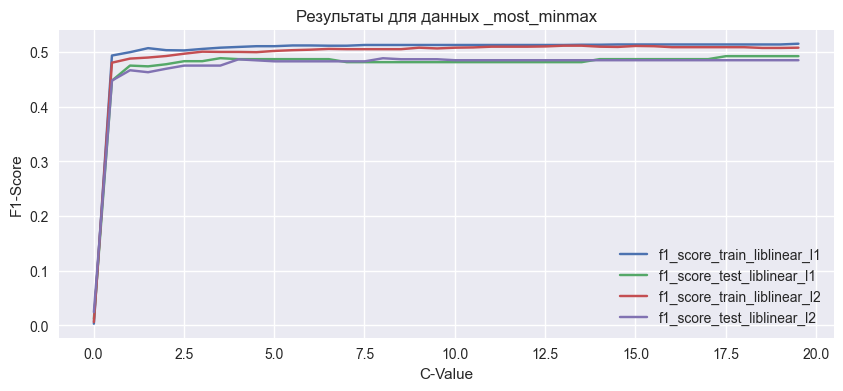

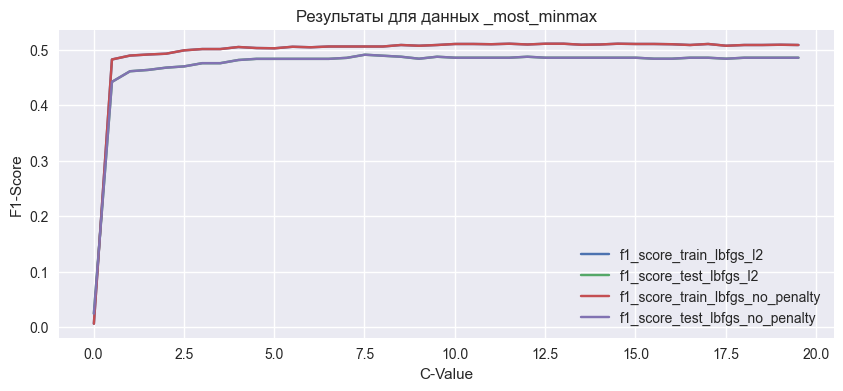

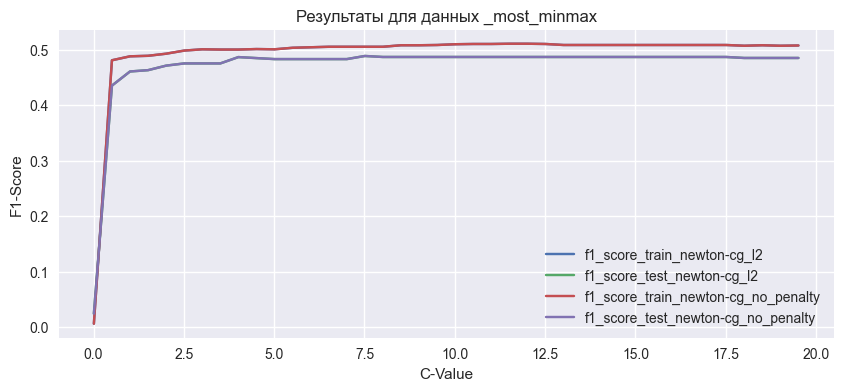

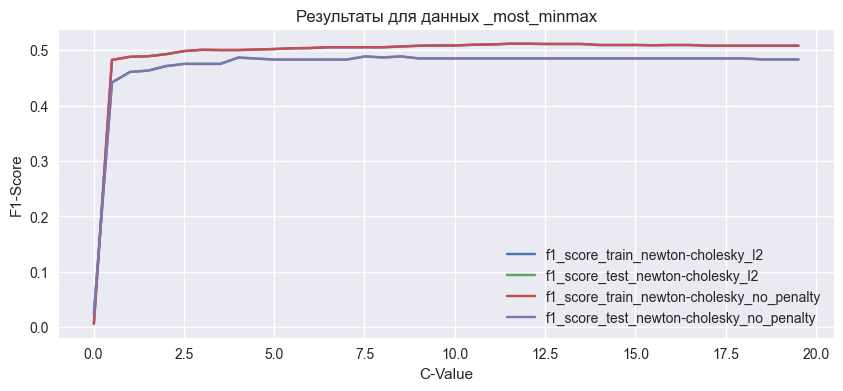

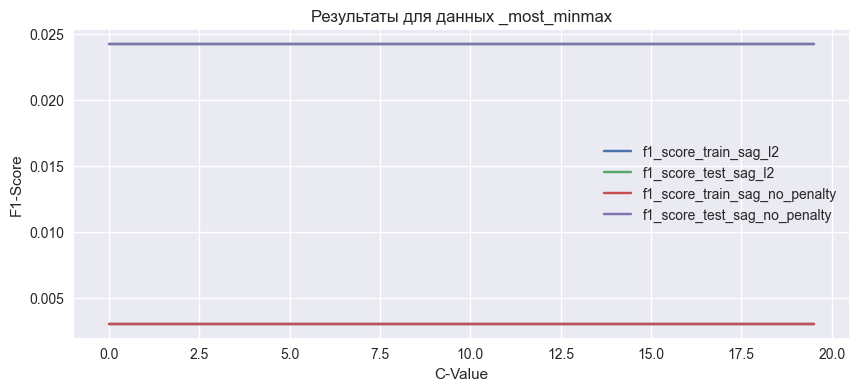

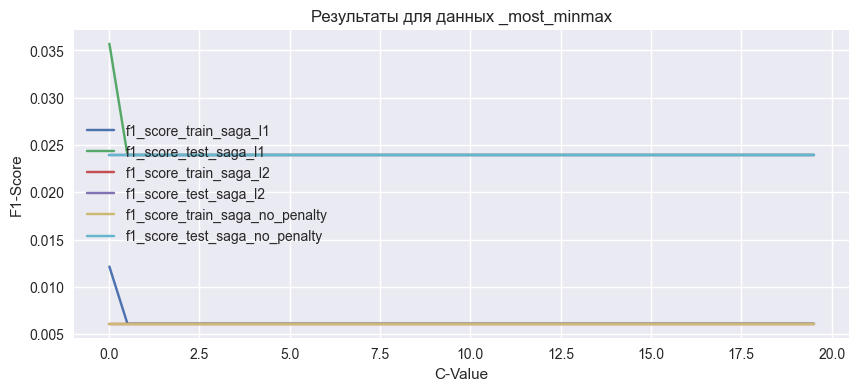

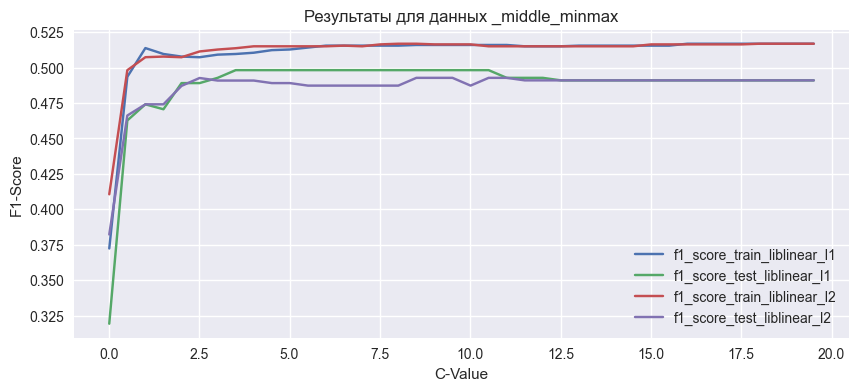

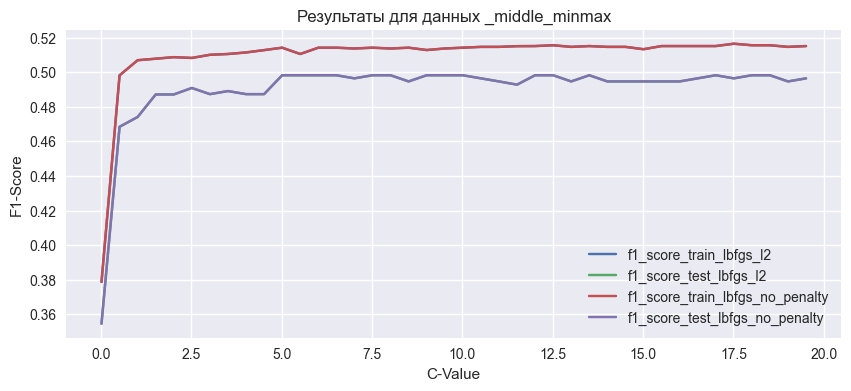

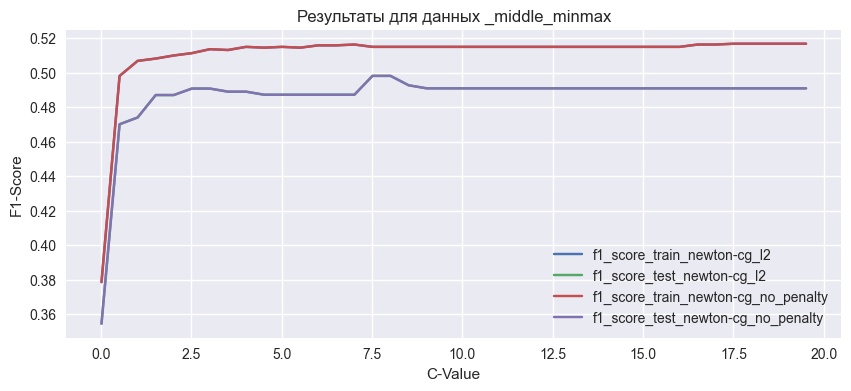

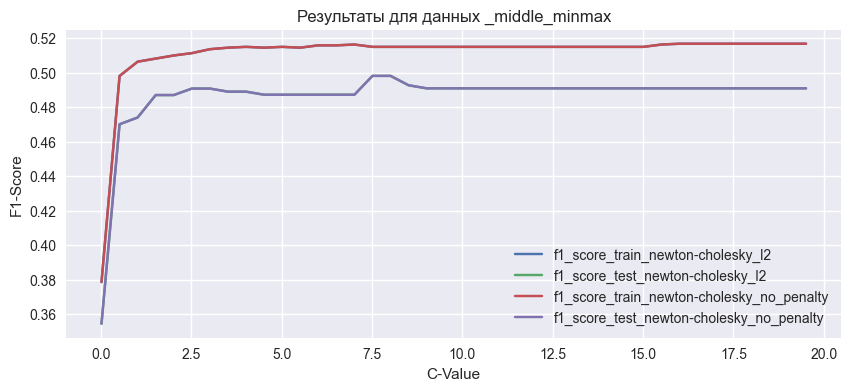

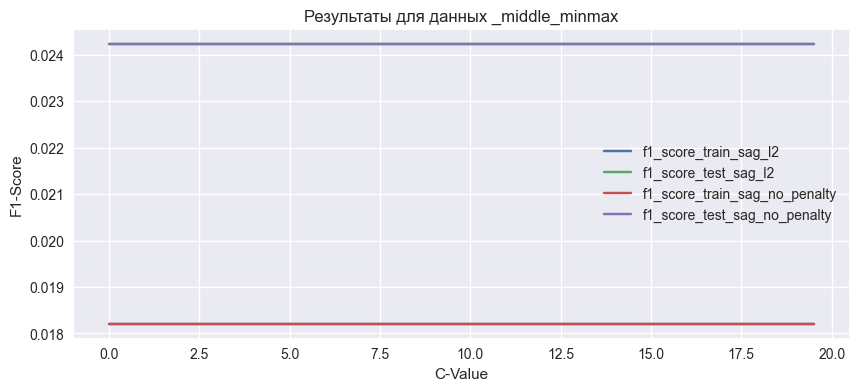

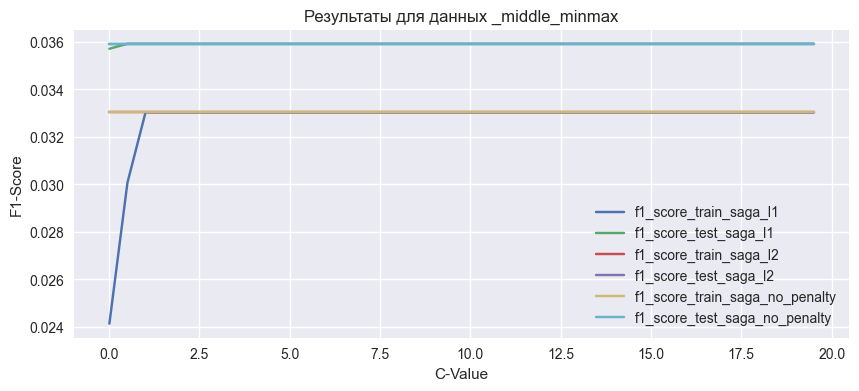

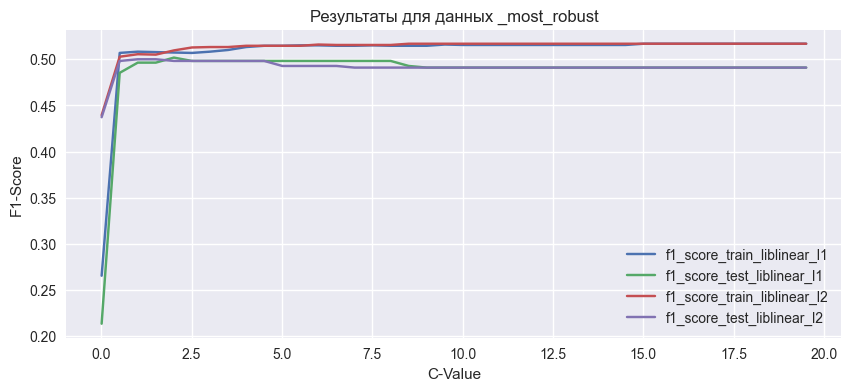

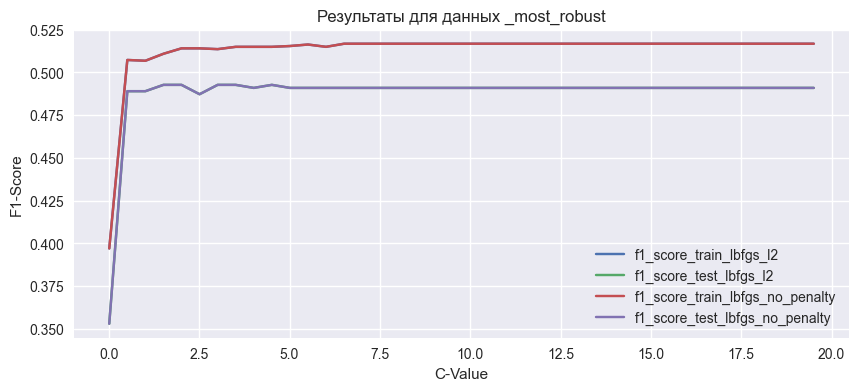

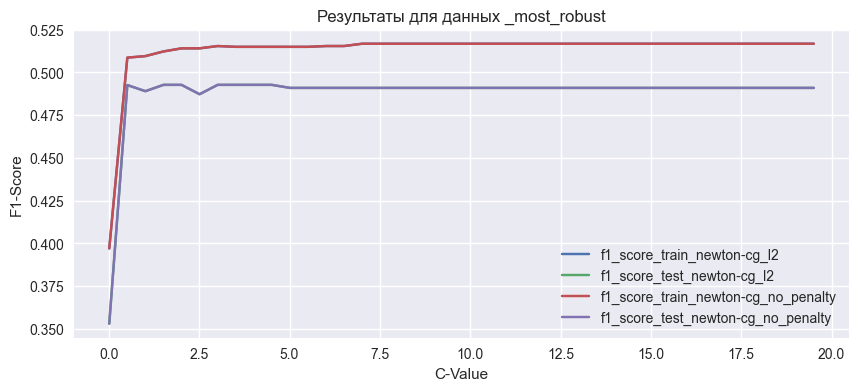

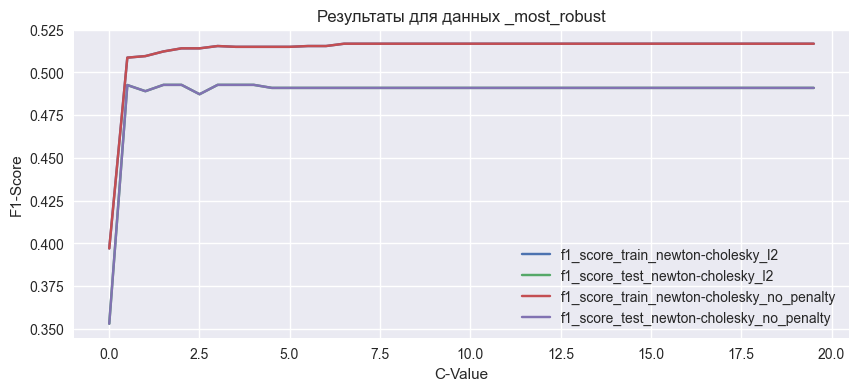

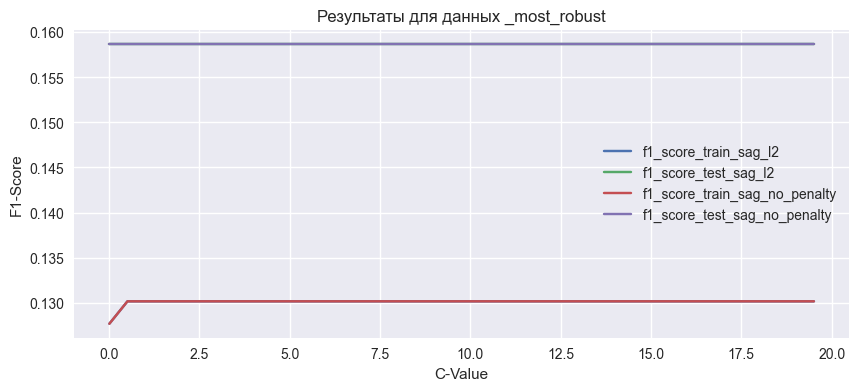

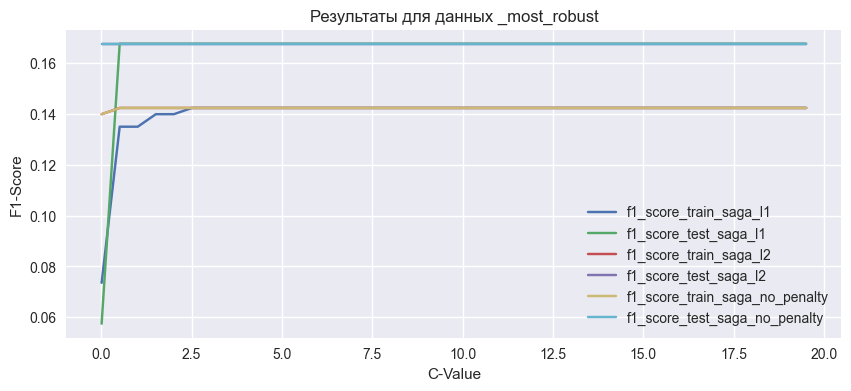

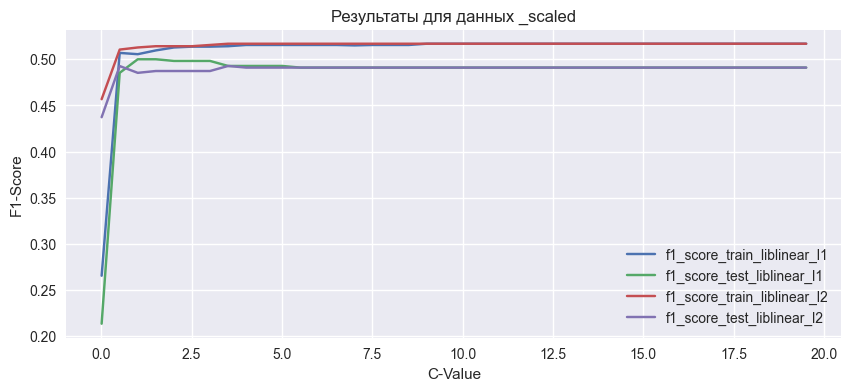

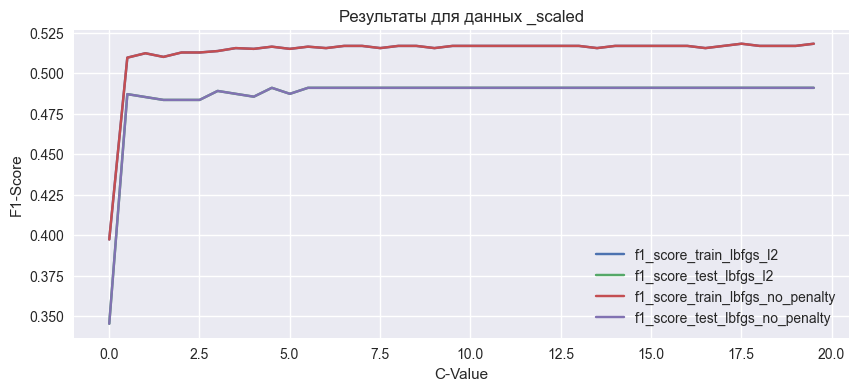

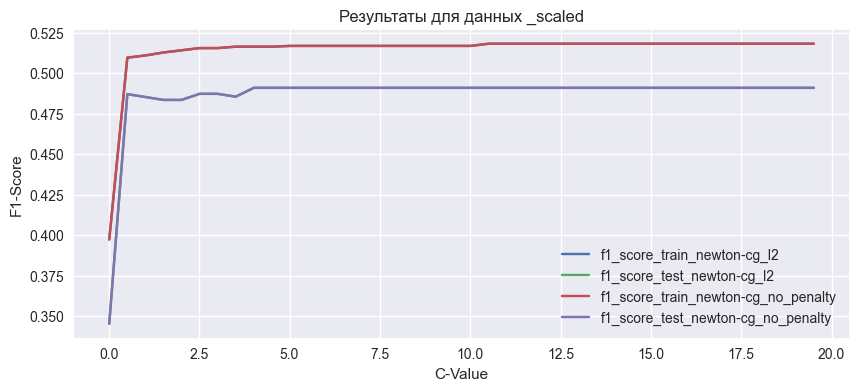

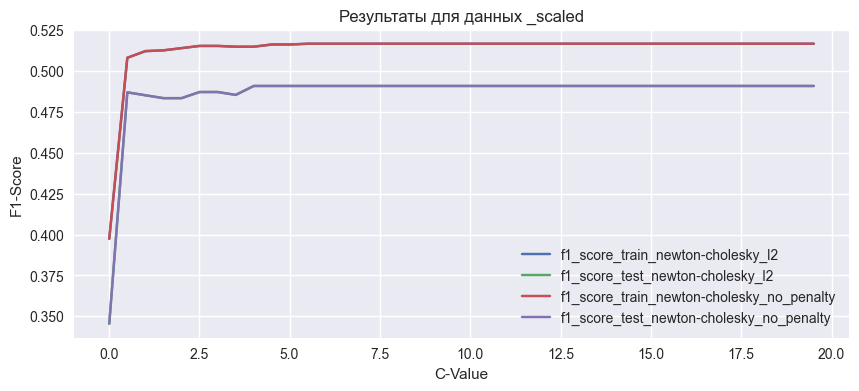

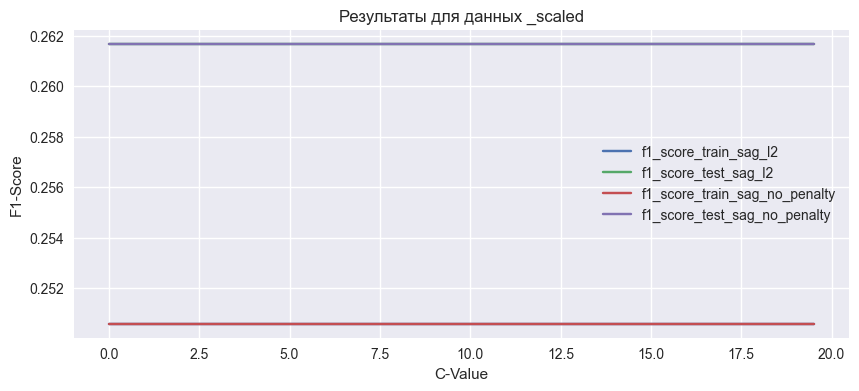

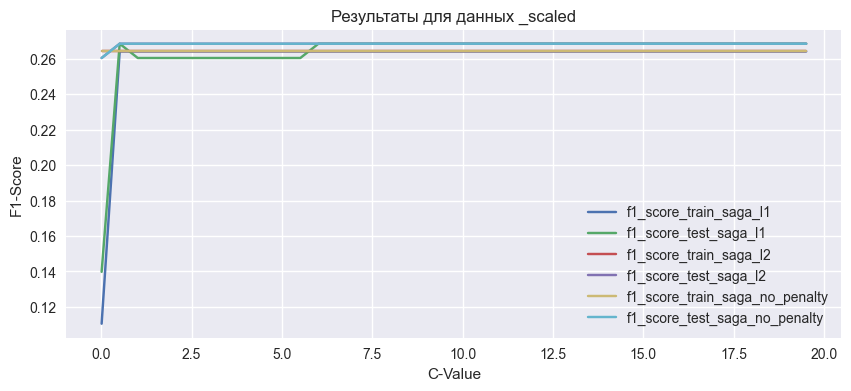

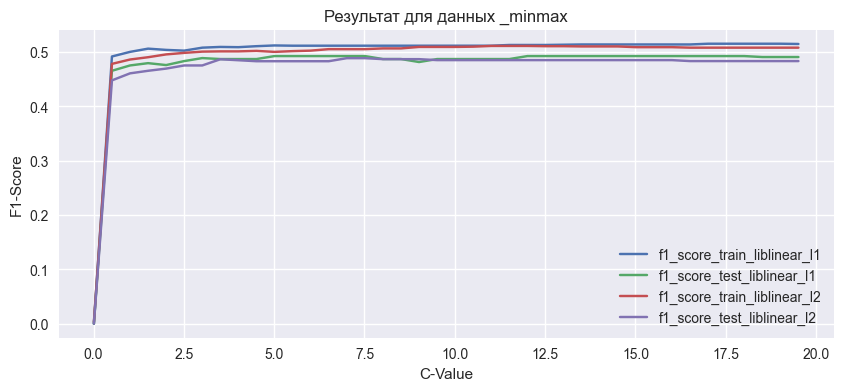

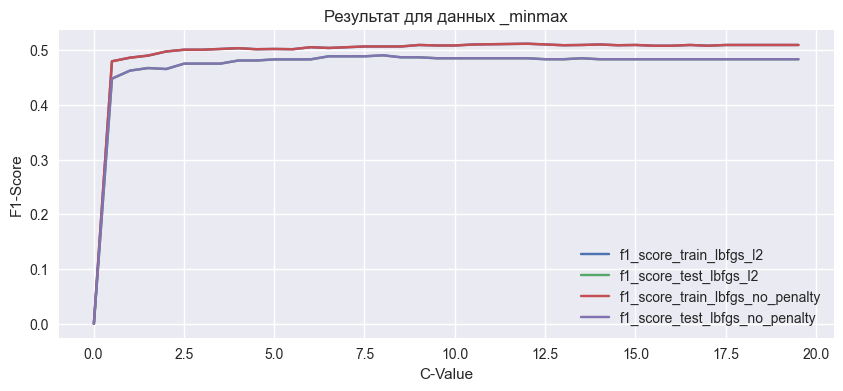

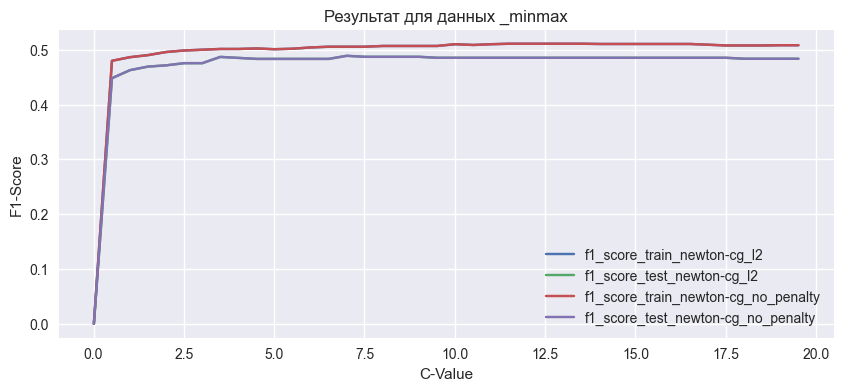

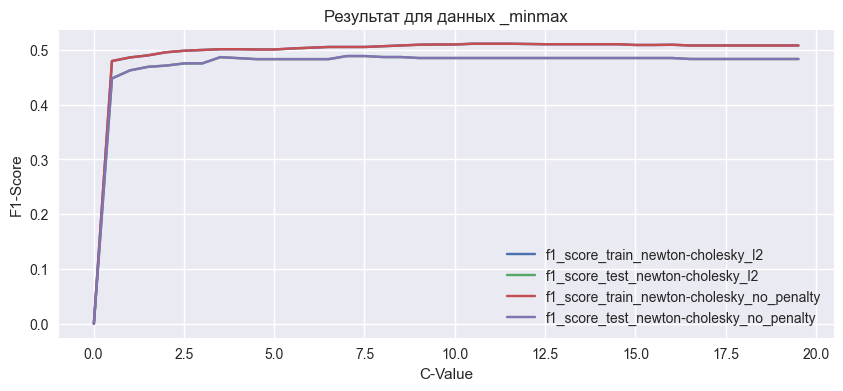

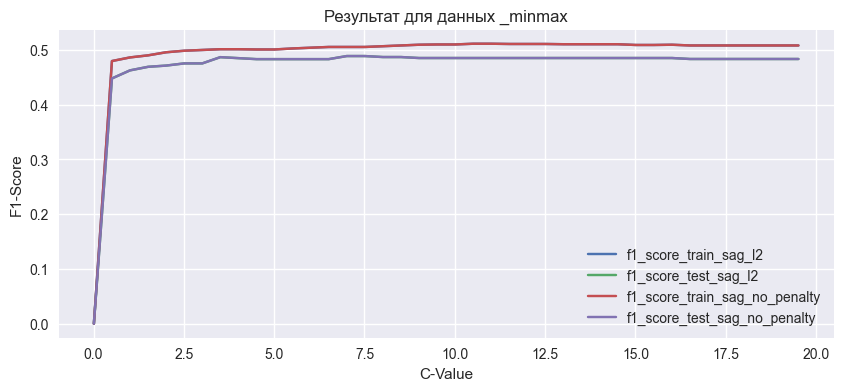

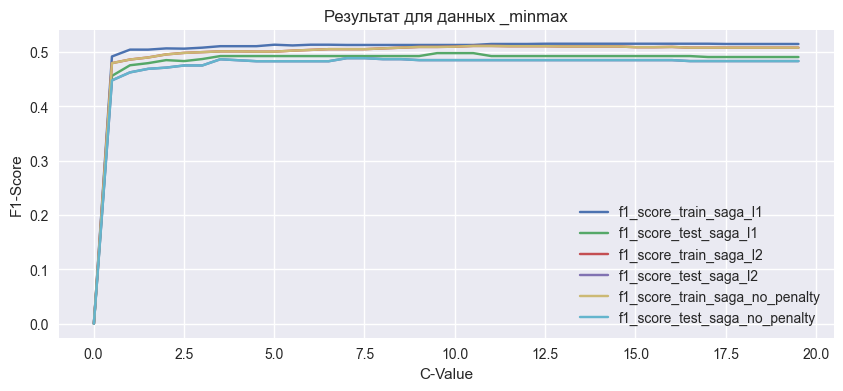

In [44]:
# Циклом подадаим на нашу функцию нормализованные данные

for X_train, X_test, standartisation_name in variety_scalings_list:
    logreg_param_select(X_train, X_test, standartisation_name, C_values = (0.01, 20, 0.5))

Проанализировав построенные графики, мы можем наблюдать, что в принципе, разные методы нормализации данных, а так же разные численные методы оптимизации функции потерь, а так же методы регуляризации, в вариативности C-фактора, дают неплохие результаты. 

Остановим свой выбор на следующих параметрах:

- Метод нормализации данных - MinMax 

- Численный метод оптимизации функции потерь логистической регрессии - saga 

- Метод регуляризации - l1

- Значение C-фактора = 10

Обучим модель логистической регрессии на этих данных, произведем прогнозирование и выведем на экран значения f1-метрик.

In [45]:
log_reg = linear_model.LogisticRegression(
    solver= 'saga', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty = 'l1',
    C=10
    )

log_reg.fit(X_train_minmax, y_train)

y_train_pred = log_reg.predict(X_train_minmax)
print(metrics.f1_score(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_minmax)
print(metrics.f1_score(y_test, y_test_pred))


0.5131938125568699
0.4981949458483754


**NТУТ ГОТОВОЕ ЗАКАНЧИВАЕТСЯ**

In [98]:
# ######################
# ОРИГИНАЛ!!!!!!  #######
#  НЕ УДАЛЯТЬ!!!!! ######
#########################



# def data_choosing(X_train, X_test, standartisation_name):
#     # print(standartisation_name)
#     # display(X_train)
#     # display(X_test)
#     # print(y_train)
#     # print('+++++++++++++++++++')
    
#     # Создаем словарь, куда будем заносить значения метрик моделей с учетом типов
#     C_factor_dict = {}
    
#     for C_factor in np.arange(0.05, 1, 0.05):
        
#         # Создаем пару-ключ словаря
#         C_factor_dict.setdefault('C_factor', [])
#         C_factor_dict['C_factor'].append(C_factor)
        

#         for reg_type in ['l1', 'l2']:
#             # Создаем объект класса логистическая регрессия
#             log_reg = linear_model.LogisticRegression(
#                 solver='saga', #алгоритм оптимизации
#                 random_state=42, #генератор случайных чисел
#                 max_iter=1000, #количество итераций на сходимость
#                 penalty = reg_type,
#                 C=C_factor
#                 )
            
#             #Обучаем модель, минимизируя logloss
#             log_reg.fit(X_train, y_train)
            
#             C_factor_dict.setdefault(f'f1_score_train_{reg_type}', [])
#             C_factor_dict.setdefault(f'f1_score_test_{reg_type}', [])
            
            
#             #Делаем предсказание для тренировочной выборки
#             y_train_pred = log_reg.predict(X_train)
#             # Заносим данные в словарь
#             C_factor_dict[f'f1_score_train_{reg_type}'].append(
#                 metrics.f1_score(y_train, y_train_pred)
#                 )
            
#             #Делаем предсказание для тестовой выборки
#             y_test_pred = log_reg.predict(X_test)
#             # Заносим данные в словарь
#             C_factor_dict[f'f1_score_test_{reg_type}'].append(
#                 metrics.f1_score(y_test, y_test_pred)
#                 )
    
#     C_factor_df = pd.DataFrame.from_dict(C_factor_dict)
#     col_list = list(C_factor_df.columns)
#     col_list.remove('C_factor')
    
#     fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#     #Строим линейный график зависимости recall от threshold
#     ax.plot(C_factor_df['C_factor'], C_factor_df[f'{col_list[0]}'], label=f'{col_list[0]}')
#     ax.plot(C_factor_df['C_factor'], C_factor_df[f'{col_list[1]}'], label=f'{col_list[1]}')
#     ax.plot(C_factor_df['C_factor'], C_factor_df[f'{col_list[2]}'], label=f'{col_list[2]}')
#     ax.plot(C_factor_df['C_factor'], C_factor_df[f'{col_list[3]}'], label=f'{col_list[3]}')
#     ax.legend()
#     ax.set_ylabel('F1-Score')
#     ax.set_xlabel('C-Value')
#     ax.set_title(f'{standartisation_name}')

        

**!!!!!!!!!!!!!!!!!**

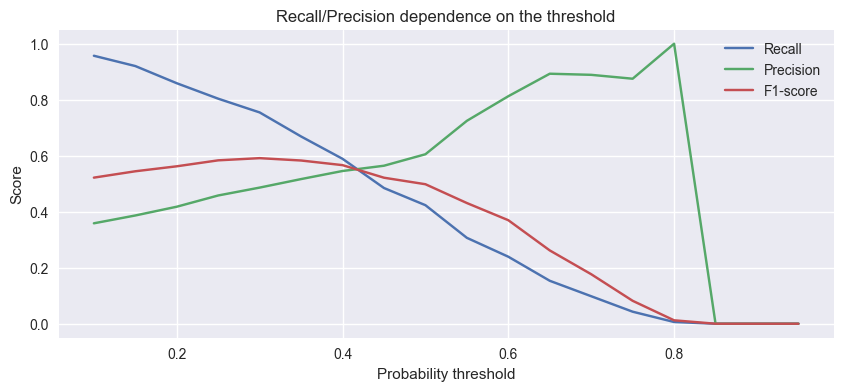

In [46]:
#### МОДЕЛЬ РАБОЧАЯ НА 10-02

#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg.predict_proba(X_test_minmax)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [54]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.3
#Людей, у которых вероятность зарабатывать >50K больше 0.4 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.84      0.62      0.71       339
           1       0.49      0.75      0.59       163

    accuracy                           0.66       502
   macro avg       0.66      0.69      0.65       502
weighted avg       0.72      0.66      0.67       502



In [87]:
y_test_df = pd.DataFrame(y_test)
y_test_pred_opt_df = pd.DataFrame(y_test_pred_opt, columns=['exited_pred'])


In [88]:
y_test_df = y_test_df.reset_index()

In [90]:
y_test_df = y_test_df.drop('index', axis=1)

In [91]:
y_test_df

,Exited
0,0
1,1
2,1
3,0
4,0
...,...
497,1
498,0
499,1
500,0


In [92]:
y_test_conc_df = pd.concat((y_test_df, y_test_pred_opt_df), axis=1, ignore_index=False)

In [98]:
y_test_conc_df['Exited'].value_counts()

Exited
0    339
1    163
Name: count, dtype: int64

In [99]:
y_test_conc_df['exited_pred'].value_counts()


exited_pred
1    253
0    249
Name: count, dtype: int64

In [101]:
y_test_conc_df[(y_test_conc_df['Exited'] == y_test_conc_df['exited_pred']) & (y_test_conc_df['Exited'] == 1)]

,Exited,exited_pred
7,1,1
9,1,1
16,1,1
18,1,1
20,1,1
...,...,...
475,1,1
479,1,1
490,1,1
493,1,1


> И так, на данном этапе мы обучили модель логистической регрессии и подобрали для нее такие параметры, а так же подобрали такой оптимальный порог вероятности, при которых метрика F1-score дает нам на тестовых данных оценку в 0.59. 

> Анализируя остальные метрики, например, precision, мы можем сказать, что построенная модель, при работе на тестовых данных с заданными нами параметрами, дала чуть больше половины ложноположительных результатов (1-0.49). 

> Но, что важно, при этом, мы попали и вычислили 3/4 ушедших клиентов, опираясь на значение метрики recall. 

> Если резюмировать, при отсутствии точного задания, в плане того, на сколько важно для компании отсутствие ложноположительных результатов, можно сказать, что определение 3/4 ушедших клиентов является достаточно хорошим показателем. 

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [ ]:
# Создаем генератор полиномиальных признаков третей степени
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)

poly.fit(X_train_minmax)

# Генерируем полиноминальные признаки на тренировочной и тестовой выборках, 
# с которыми приняли решение, что будем работать
X_train_minmax_poly = poly.transform(X_train_minmax)
X_test_minmax_poly = poly.transform(X_test_minmax)

# Создаем модель логистической регрессии, задаем параметры аналогичные тем, 
# что были в моделе ранее, как "промежуточно-итоговой"
log_reg_poly = linear_model.LogisticRegression(
    solver='saga', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty = 'l1',
    C=10
    )

# Обучаем модель
log_reg_poly.fit(X_train_minmax_poly, y_train)

# Делаем прогнозы и выводим метрики на экран
y_train_pred_poly = log_reg_poly.predict(X_train_minmax_poly)
print(metrics.f1_score(y_train, y_train_pred_poly))

y_test_pred_poly = log_reg_poly.predict(X_test_minmax_poly)
print(metrics.f1_score(y_test, y_test_pred_poly))

0.7141687141687142
0.6819672131147541


,C_factor,f1_score_train_saga_l1,f1_score_test_saga_l1,f1_score_train_saga_l2,f1_score_test_saga_l2,f1_score_train_saga_no_penalty,f1_score_test_saga_no_penalty
0,0.01,0.000000,0.000000,0.364497,0.294416,0.364497,0.294416
1,1.01,0.680924,0.659864,0.645219,0.628975,0.645219,0.628975
2,2.01,0.699582,0.668896,0.675370,0.641379,0.675370,0.641379
3,3.01,0.698492,0.679868,0.683805,0.646048,0.683805,0.646048
4,4.01,0.707358,0.668874,0.689362,0.641638,0.689362,0.641638
5,5.01,0.705882,0.673267,0.697635,0.648649,0.697635,0.648649
6,6.01,0.704715,0.673267,0.700422,0.653333,0.700422,0.653333
7,7.01,0.707819,0.668874,0.703112,0.657718,0.703112,0.657718
8,8.01,0.712059,0.668874,0.706376,0.657718,0.706376,0.657718
9,9.01,0.714169,0.681967,0.707358,0.659933,0.707358,0.659933


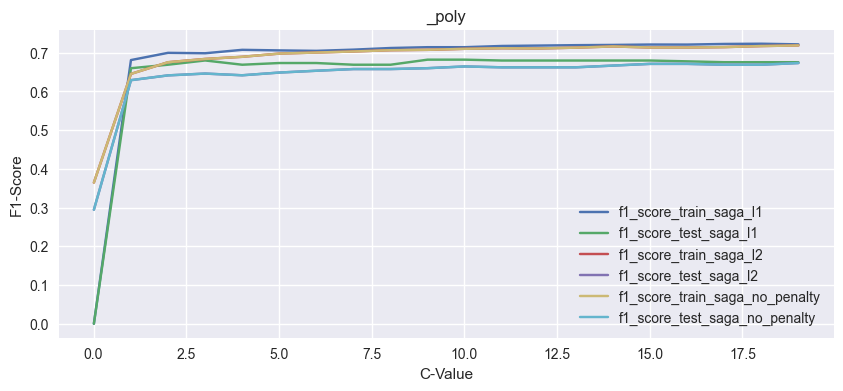

In [ ]:
# Воспользуемся ранее написанной функцией для подбора параметров модели
logreg_param_select(
    X_train_minmax_poly, X_test_minmax_poly, standartisation_name='_poly', 
    solver_names=['saga'], penalty_method=['all'],
    C_values = (0.01, 20, 1))

> Использование полиномиальных признаков позвололо существенно улучшить метрику нашей модели. Значение f1 метрики для тренировочной выборке увеличилось с 0.513 до 0.714, значение метрики на тестовой выборке увеличилось с 0.498 до 0.682. 

> При этом, была осуществлена проверка параметров логистической регрессии на выборке с полиномиальными признаками, которая показала, что ранее выбранные параметры при работе модели с обычными признаками верны так же и для этой модели, как дающие наиболее высокий результат. 

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

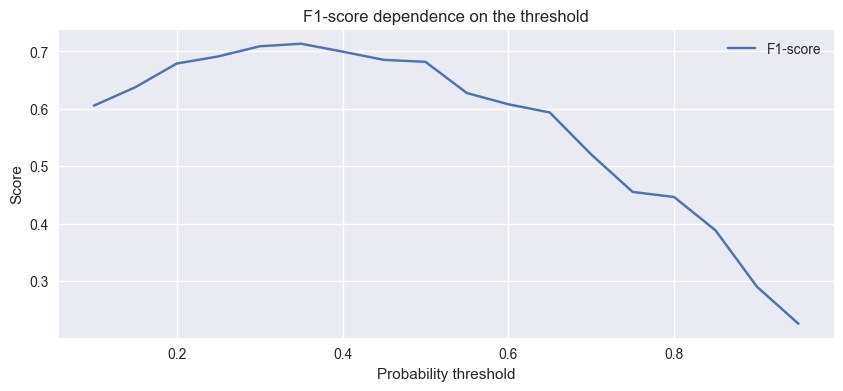

In [106]:
# Ваш код здесь

# Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred_poly = log_reg_poly.predict_proba(X_test_minmax_poly)[:, 1]
# Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred_poly = pd.Series(y_test_proba_pred_poly)

# Создадимок, в котором будем хранить значения метрики 
f1_scores_poly = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred_poly = y_test_proba_pred_poly.apply(
        lambda x: 1 if x > threshold else 0
        )
    # Считаем метрикe и добавляем ее в список

    f1_scores_poly.append(metrics.f1_score(y_test, y_test_pred_poly))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores_poly, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('F1-score dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()

А теперь, для более качественного вывода, сделаем отчет по метрикам, чтобы видеть картину более широко. 

In [110]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.37
#Людей, у которых вероятность зарабатывать >50K больше 0.4 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt_poly = y_test_proba_pred_poly.apply(
    lambda x: 1 if x > threshold_opt else 0
    )
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt_poly))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       339
           1       0.67      0.77      0.72       163

    accuracy                           0.80       502
   macro avg       0.78      0.80      0.78       502
weighted avg       0.81      0.80      0.81       502



**Вывод:** 

- Использование полиномиальных признаков позволило существенно улучшить заданную метрику модели. 

- При этом, ориентируясь на показатель recall, мы можем сказать, что количество выявленных действительно ушедших клиентов выросло не значительно, по сравнению с тем, когда модель работала на обычных признаков теперь мы верно определили чуть более 3/4 ушедщих пользователей. 

- Но, зато, мы видим существенный прирост метрики precision, которая говорит нам о том, что если до этого мы ложноположительно определеили 51 процент, то сейчас 33 процента. Таким образом, принимая во внимание, что на удержание клиентов компанией будут затрачиваться финансовые ресурсы, улучшение этого показателя на 18 процентов является **хорошим достижением финансовой экономии**. 

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [ ]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь